### 本节课调用adaboost以及基于简单决策树实现adaboost模型  

#### 我们将利用adaboost模型对肿瘤类型进行判断与分类

- 数据来源： https://www.kaggle.com/uciml/breast-cancer-wisconsin-data  
- 对比模型： Adaboost模型

In [5]:
# necessary imports
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

np.random.seed(19)

In [7]:
data_folder = ""
#data_folder = "data"
data = pd.read_csv(os.path.join(data_folder, "breastCancer.csv"))

In [8]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### 检查需要预测的目标

In [9]:
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

#### 过滤不需要的信息

In [10]:
data.drop('id',axis=1,inplace=True)
data.drop('Unnamed: 32',axis=1,inplace=True)

#### 转换预测的目标   M：1， B：-1

In [11]:
data['diagnosis'] = data['diagnosis'].apply(lambda x : +1 if x=='M' else -1)

#### 观察数据的基本信息

In [12]:
data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,-0.254833,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.967836,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,-1.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,-1.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,-1.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [14]:
import seaborn as sns
sns.countplot(data['diagnosis'])

ModuleNotFoundError: No module named 'seaborn'

#### 利用前6个特征，设定目标变量

In [15]:
features = data.columns[1:7]
target = 'diagnosis'
features

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean'],
      dtype='object')

#### 特征探索  

- 比较6个特征与恶性肿瘤的关系

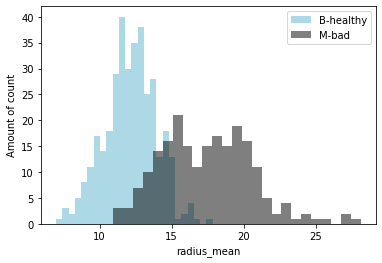

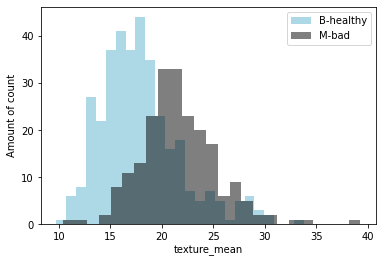

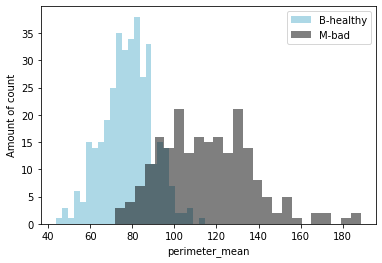

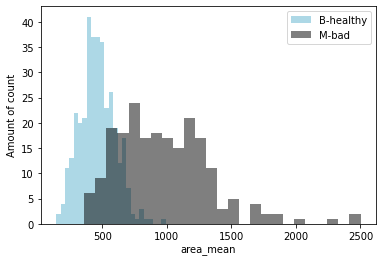

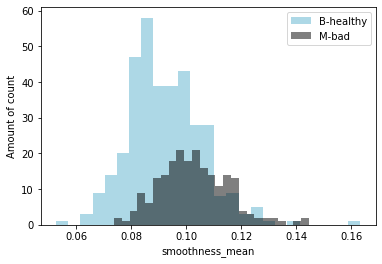

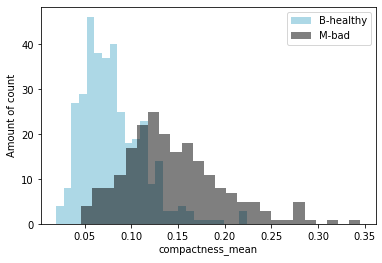

In [16]:
i = 0
for feature in features:

    bins = 25
    # 将特征的直方图画出来
    plt.hist(data[feature][data[target] == -1], bins=bins, color='lightblue', label= 'B-healthy', alpha=1)
    plt.hist(data[feature][data[target] == 1], bins=bins, color='k', label='M-bad', alpha=0.5)
    
    plt.xlabel(feature)
    plt.ylabel('Amount of count')
    
    plt.legend()
    
    plt.show()

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.3)

In [18]:
trainX, trainY = train_data[data.columns[1:]], train_data[target]
testX, testY = test_data[data.columns[1:]], test_data[target]

### Logistic回归的表现

In [19]:
logistic_model = LogisticRegression()
print("Logistic Regression performance: %f" % (cross_val_score(logistic_model, trainX, trainY, cv=8).mean()))

Logistic Regression performance: 0.939592


/Users/yurzhou/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yurzhou/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

### 决策树的表现

In [20]:
tree_model = DecisionTreeClassifier()
print("Decision Tree performance: %f" % (cross_val_score(tree_model, trainX, trainY, cv=8).mean()))

Decision Tree performance: 0.906990


### 直接调用adaboost模型的表现

In [21]:
ada_model = AdaBoostClassifier(n_estimators=200)
print("Decision Tree performance: %f" % (cross_val_score(ada_model, trainX, trainY, cv=8).mean()))

Decision Tree performance: 0.967347


### 测试集的表现

In [22]:
logistic_model = LogisticRegression()
logistic_model.fit(trainX, trainY)
print("Logistic Regression test performance: %f" % logistic_model.score(testX, testY))

Logistic Regression test performance: 0.935673


/Users/yurzhou/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
tree_model = DecisionTreeClassifier()
tree_model.fit(trainX, trainY)
print("Decision Tree test performance: %f" % tree_model.score(testX, testY))

Decision Tree test performance: 0.935673


In [24]:
ada_model = AdaBoostClassifier(n_estimators=200)
ada_model.fit(trainX, trainY)
print("Adaboost test performance: %f" % ada_model.score(testX, testY))

Adaboost test performance: 0.953216


#### Adaboost的实现

In [25]:
from sklearn.base import BaseEstimator
class Adaboost(BaseEstimator):
    
    def __init__(self, M):
        self.M = M
        
    def fit(self, X, Y):
        self.models = []
        self.model_weights = []
        
        N, _ = X.shape
        alpha = np.ones(N) / N
        
        for m in range(self.M):
            tree = DecisionTreeClassifier(max_depth=2)
            tree.fit(X, Y, sample_weight=alpha)
            prediction = tree.predict(X)
            
            # 计算加权错误
            weighted_error = alpha.dot(prediction != Y)
            
            # 计算当前模型的权重
            model_weight = 0.5 * (np.log(1 - weighted_error) - np.log(weighted_error))
            
            # 更新数据的权重
            alpha = alpha * np.exp(-model_weight * Y * prediction)
            
            # 数据权重normalize
            alpha = alpha / alpha.sum()
            
            self.models.append(tree)
            self.model_weights.append(model_weight)
            
    def predict(self, X):
        N, _ = X.shape
        result = np.zeros(N)
        for wt, tree in zip(self.model_weights, self.models):
            result += wt * tree.predict(X)
        
        return np.sign(result)
    
    def score(self, X, Y):
        prediction = self.predict(X)
        return np.mean(prediction == Y)

### Adaboost的表现

In [28]:
adamodel = Adaboost(200)
print("Adaboost model performance: %f" % (cross_val_score(adamodel, trainX.to_numpy().astype(np.float64), trainY.to_numpy().astype(np.float64), cv=8).mean()))

Adaboost model performance: 0.972449


### 测试集的表现

In [31]:
adamodel.fit(trainX.to_numpy().astype(np.float64), trainY.to_numpy().astype(np.float64))
print("Adaboost model test performance: %f" % adamodel.score(testX.to_numpy().astype(np.float64), testY.to_numpy().astype(np.float64)))

Adaboost model test performance: 0.941520
